In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
import random
import statsmodels.api as sm
from collections import namedtuple
import pandas as pd
import math
from scipy.optimize import minimize

### Week 3 


Simulate AR(1) process and plotting the empirical 5 % autocorrelation function

In [2]:
phi = np.array([-0.8, 0.4, 0.9, 1.01]).reshape(1,4)
c = 2
sigma = 1

T = 200

x = np.zeros((T,phi.shape[1]))
x[0,:] = c/(1- phi) ## setting first row as unconditional mean

for j in range(phi.shape[1]):
    for t in range(1,T):
        x[t,j] = phi[0,j]*x[t-1,j] + np.random.normal()*sigma

In [3]:
x.shape

(200, 4)

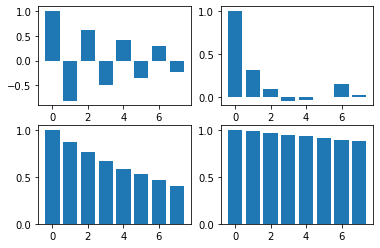

In [4]:
##plotting ACF
lags = range(8)
fig,ax = plt.subplots(2,2)
ax = ax.ravel()

for i,ax_i in enumerate(ax):
    ax_i.bar(np.arange(len(lags)), sm.tsa.acf(x[:,i], nlags = len(lags)-1))


In [5]:
## function to generate error bands

def rhohat(y,lags,conf_int):
    T = len(y)
    y_demeaned = y - np.mean(y)
    
    ac = np.zeros(lags+1)
    var = np.var(y)
    
    for i in range(lags+1):
        if i == 0:
            ac[i] = 1
        else:
            ac[i] = np.sum((y_demeaned[i:]) * (y_demeaned[:-i])) / ((T) * var)
        
    critval = scipy.stats.norm.ppf(1-conf_int/2)
    ul = np.tile(critval/np.sqrt(T), lags)
    ll = -1*ul
    
    return ac[1:],ul,ll

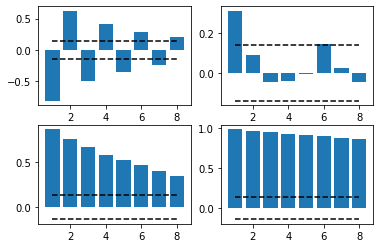

In [6]:
##plotting ACF
lags = range(8)
fig,ax = plt.subplots(2,2)
ax = ax.ravel()

for i,ax_i in enumerate(ax):
    ac,ul,ll = rhohat(x[:,i],8,0.05)
    ax_i.bar(np.arange(1,len(lags)+1), ac)
    ax_i.plot(np.arange(1,len(lags)+1), ul, ls = '--', c = 'k')
    ax_i.plot(np.arange(1,len(lags)+1), ll, ls = '--', c = 'k')

### Week 4 

Write a function OLS = ARpOLS(y,p,const,alpha) that takes as inputs a data vector y and number of lags p. The input const is 1 if there is a constant in the model, 2 if there is a constant and a linear trend. The function outputs a structure OLS, which contains the OLS estimates of θ, its standard errors, t-statistics and p-values given significance value $\alpha$, as well as the OLS estimate of $\sigma_u$.

In [7]:
## helper functions

def lagmatrix(x,p):
    """
    Creates a matrix of lagged values from 1D array.
    Input:
    x = 1D array
    p = number of lags
    
    Output:
    lagmat = A matrix with p columns and rows equal to length of x
    """
    lagmat = np.zeros((x.shape[0],p))
    for i in range(p):
        lagmat[i+1:,i] = x[:-i-1]
    return lagmat

In [8]:
def ARpOLS(y,p,const,alpha):
    T = y.shape[0]
    T_eff = T-p
    Y = lagmatrix(y,p) 
    if const == 1:
        Y = np.concatenate([np.ones(T)[:, np.newaxis], Y], axis = 1)
    else:
        Y = np.concatenate([np.ones(T)[:, np.newaxis], np.arange(1,T+1)[:, np.newaxis], Y], axis = 1)
    Y = Y[p:,:]
    y = y[p:]
    
    YtYinv = np.linalg.inv(Y.T@Y)
    thetahat = YtYinv@(Y.T@y)
    yhat = Y@thetahat
    uhat = y - yhat
    utu = uhat.T@uhat
    
    var_uhat = utu/(T_eff - p - const)
    siguhat = np.sqrt(var_uhat)
    var_thetahat = var_uhat*(np.diag(YtYinv))
    sd_thetahat = np.sqrt(var_thetahat)
    
    tstat = thetahat/sd_thetahat # t−statistics
    tcrit = -1*scipy.stats.t.ppf(alpha/2, T_eff-p-const) # critical value
    pvalues = scipy.stats.t.pdf(tstat,T_eff-p-const) # p−value
    theta_ci=(thetahat - tcrit*sd_thetahat, thetahat+tcrit*sd_thetahat)
    
    return {"T_eff": T_eff, 
            "thetahat" : thetahat, 
            "siguhat" : siguhat, 
            "sd_thetahat" : sd_thetahat,
            "tstat" : tstat,
            "pvalues" : pvalues,
            "theta_ci" : theta_ci,
            "resid" : uhat}

In [9]:
data = pd.read_csv('data/AR4.csv')
data['AR4;'] = data['AR4;'].apply(lambda x: float(x[:-1])) 
data.head(3)

,AR4;
0,1.6150
1,2.8231
2,2.9714


In [10]:
OLS = ARpOLS(data.values.reshape((195,)), 4, const = 1, alpha = 0.05)

In [11]:
OLS['thetahat']

array([ 1.05383917,  0.39610127, -0.05732461,  0.02828328, -0.18756322])

In [12]:
OLS['siguhat']

0.504673056885094

Write a function LogLikeARpNorm(x,y,p,const) that computes the value of the log-likelihood conditional on the first p observations of a Gaussian AR(p) model, y denotes the data vector, p the number of lags and const is equal to 1 if there is a constant, and equal to 2 if there is a constant and linear trend in the model.

In [63]:
def loglikARpNorm(x,y,p,const):
    
    theta = x[:const+p]
    sig_u = x[-1]
    
    
    T = y.shape[0]
    Y = lagmatrix(y,p)

    if const == 1:
        Y = np.concatenate([np.ones(T)[:, np.newaxis], Y], axis = 1)
    else:
        Y = np.concatenate([np.ones(T)[:, np.newaxis], np.arange(1,T+1)[:, np.newaxis], Y], axis = 1)
    Y = Y[p:,:]
    y = y[p:]

    uhat = y - Y@theta
    utu = uhat.T@uhat

    loglik = -np.log(2*math.pi)*(T-p)/2 - np.log(sig_u**2)*(T-p)/2 - utu/(2*sig_u**2)

    if math.isnan(loglik) or math.isinf(loglik) or ~np.isreal(loglik):
        loglik = -1e10

    return -1*loglik

In [69]:
def ARpML(y,p,const,alpha):

    T = y.shape[0]

    initial_params = [0,0,0,0,0,1] #initial guess
    result = minimize(loglikARpNorm, initial_params, args = (y,p,const), )
    thetatilde, sigutilde = result.x[:p+const], result.x[-1]

    V = result.hess_inv 

    sd = np.sqrt(np.diag(V))
    sd_thetatilde = sd[:p+const]
    sd_sigmautilde = sd[-1]

    T_eff = T-p
    logl = -1*result.fun

    tstat = thetatilde/sd_thetatilde # t−statistics
    tcrit = -1*scipy.stats.t.ppf(alpha/2, T_eff-p-const) # critical value
    pvalues = scipy.stats.t.pdf(tstat,T_eff-p-const) # p−value
    theta_ci=(thetatilde - tcrit*sd_thetatilde, thetatilde+tcrit*sd_thetatilde)
    
    return {"T_eff": T_eff, 
            "thetatilde" : thetatilde, 
            "sigutilde" : sigutilde, 
            "sd_thetatilde" : sd_thetatilde,
            "sd_sigmautilde" : sd_sigmautilde,
            "tstat" : tstat,
            "pvalues" : pvalues,
            "theta_ci" : theta_ci,
            "logl" : logl}

In [70]:
mle = ARpML(data.values.reshape((195,)), 4, const = 1, alpha = 0.05)

In [71]:
mle['thetatilde']

array([ 1.05383919,  0.39610127, -0.05732463,  0.0282833 , -0.18756324])

In [72]:
mle['sigutilde']

0.49802357114673634

In [68]:
np.random.randn(4+1)

array([ 1.92371343, -0.49240339, -0.07591352, -0.54789168, -0.49446781])